# Model parameters

## Lesson goals
* Understand the role of the `max_tokens` parameter
* Use the `temperature` parameter to control model responses
* Explain the purpose of `stop_sequence`

In [1]:
import boto3

def generate_conversation(messages,
                          system_prompts=[],
                          inference_config={},
                          additional_model_fields={},
                          ):

    bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
    model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

    # Send the message.
    response = bedrock_client.converse(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )

    return response["output"]["message"]["content"][0]["text"]

messages = [{
    "role": "user",
    "content": [{"text": "hello world"}]
}]

generate_conversation(messages)

'Hi! How can I help you today?'

## Max tokens

So what is the purpose of `max_tokens`?

### Tokens
In short, `max_tokens` controls the maximum number of tokens that Claude should generate in its response.  Before we go any further, let's stop for a moment to discuss tokens.

Most Large Language Models don't "think" in full words, but instead work with a series of word-fragments called tokens. Tokens are the small building blocks of a text sequence that Claude processes, understands, and generates texts with.  When we provide a prompt to Claude, that prompt is first turned into tokens and passed to the model.  The model then begins generating its output **one token at a time**.

For Claude, a token approximately represents 3.5 English characters, though the exact number can vary depending on the language used. 

### Working with `max_tokens`

The `max_tokens` parameter allows us to set an upper limit on how many tokens Claude generates for us. As an illustration, suppose we ask Claude to write us a poem and set `max_tokens` to 10.  Claude will start generating tokens for us and immediately stop as soon as it hits 10 tokens.  This will often lead to truncated or incomplete outputs. Let's try it! 

In [2]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "Write me a poem"}]
}]

inference_config={"maxTokens":100}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
)

We can also check the `stop_reason` property on the response Message object to see WHY the model stopped generating.  In this case, we can see that it has a value of "max_tokens" which tells us the model stopped generating because it hit our max token limit! 

In [3]:
response['stopReason']

'max_tokens'

This is what we got back from Claude: 

>Here is a poem for you:
>
>The

If you run the above code, you'll likely get a different result that is equally truncated.  Claude started to write us a poem and then immediately stopped upon generating 10 tokens.  

Of course, if we try generating a poem again with a larger value for `max_tokens`, we'll likely get an entire poem:

It's important to note that the models don't "know" about `max_tokens` when generating content.  Changing `max_tokens` won't alter how Claude generates the output, it just gives the model room to keep generating (with a high `max_tokens` value) or truncates the output (with a low `max_tokens` value).

It's also important to know that increasing `max_tokens` does not ensure that Claude actually generates a specific number of tokens.  If we ask Claude to write a joke and set `max_tokens` to 1000, we'll almost certainly get a response that is much shorter than 1000 tokens.

In [4]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "Write me a poem"}]
}]

inference_config={"maxTokens":200}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    messages=messages,
    inferenceConfig=inference_config,
)

In [5]:
response["usage"]["outputTokens"]

148

### Why alter max tokens?
Understanding tokens is crucial when working with Claude, particularly for the following reasons:

* **API limits**: The number of tokens in your input text and the generated response count towards the API usage limits. Each API request has a maximum limit on the number of tokens it can process. Being aware of tokens helps you stay within the API limits and manage your usage efficiently.
* **Performance**: The number of tokens Claude generates directly impacts the processing time and memory usage of the API. Longer input texts and higher max_tokens values require more computational resources. Understanding tokens helps you optimize your API requests for better performance.
* **Response quality**: Setting an appropriate max_tokens value ensures that the generated response is of sufficient length and contains the necessary information. If the max_tokens value is too low, the response may be truncated or incomplete. Experimenting with different max_tokens values can help you find the optimal balance for your specific use case.

## Temperature

The `temperature` parameter is used to control the "randomness" and "creativity" of the generated responses. It ranges from 0 to 1, with higher values resulting in more diverse and unpredictable responses with variations in phrasing.  Lower temperatures can result in more deterministic outputs that stick to the most probable phrasing and answers. **Temperature has a default value of 1**.

When generating text, Claude predicts the probability distribution of the next token (word or subword). The temperature parameter is used to manipulate this probability distribution before sampling the next token. If the temperature is low (close to 0.0), the probability distribution becomes more peaked, with high probabilities assigned to the most likely tokens. This makes the model more deterministic and focused on the most probable or "safe" choices. If the temperature is high (closer to 1.0), the probability distribution becomes more flattened, with the probabilities of less likely tokens increasing. This makes the model more random and exploratory, allowing for more diverse and creative outputs. 

See this diagram for a visual representation of the impact of temperature:

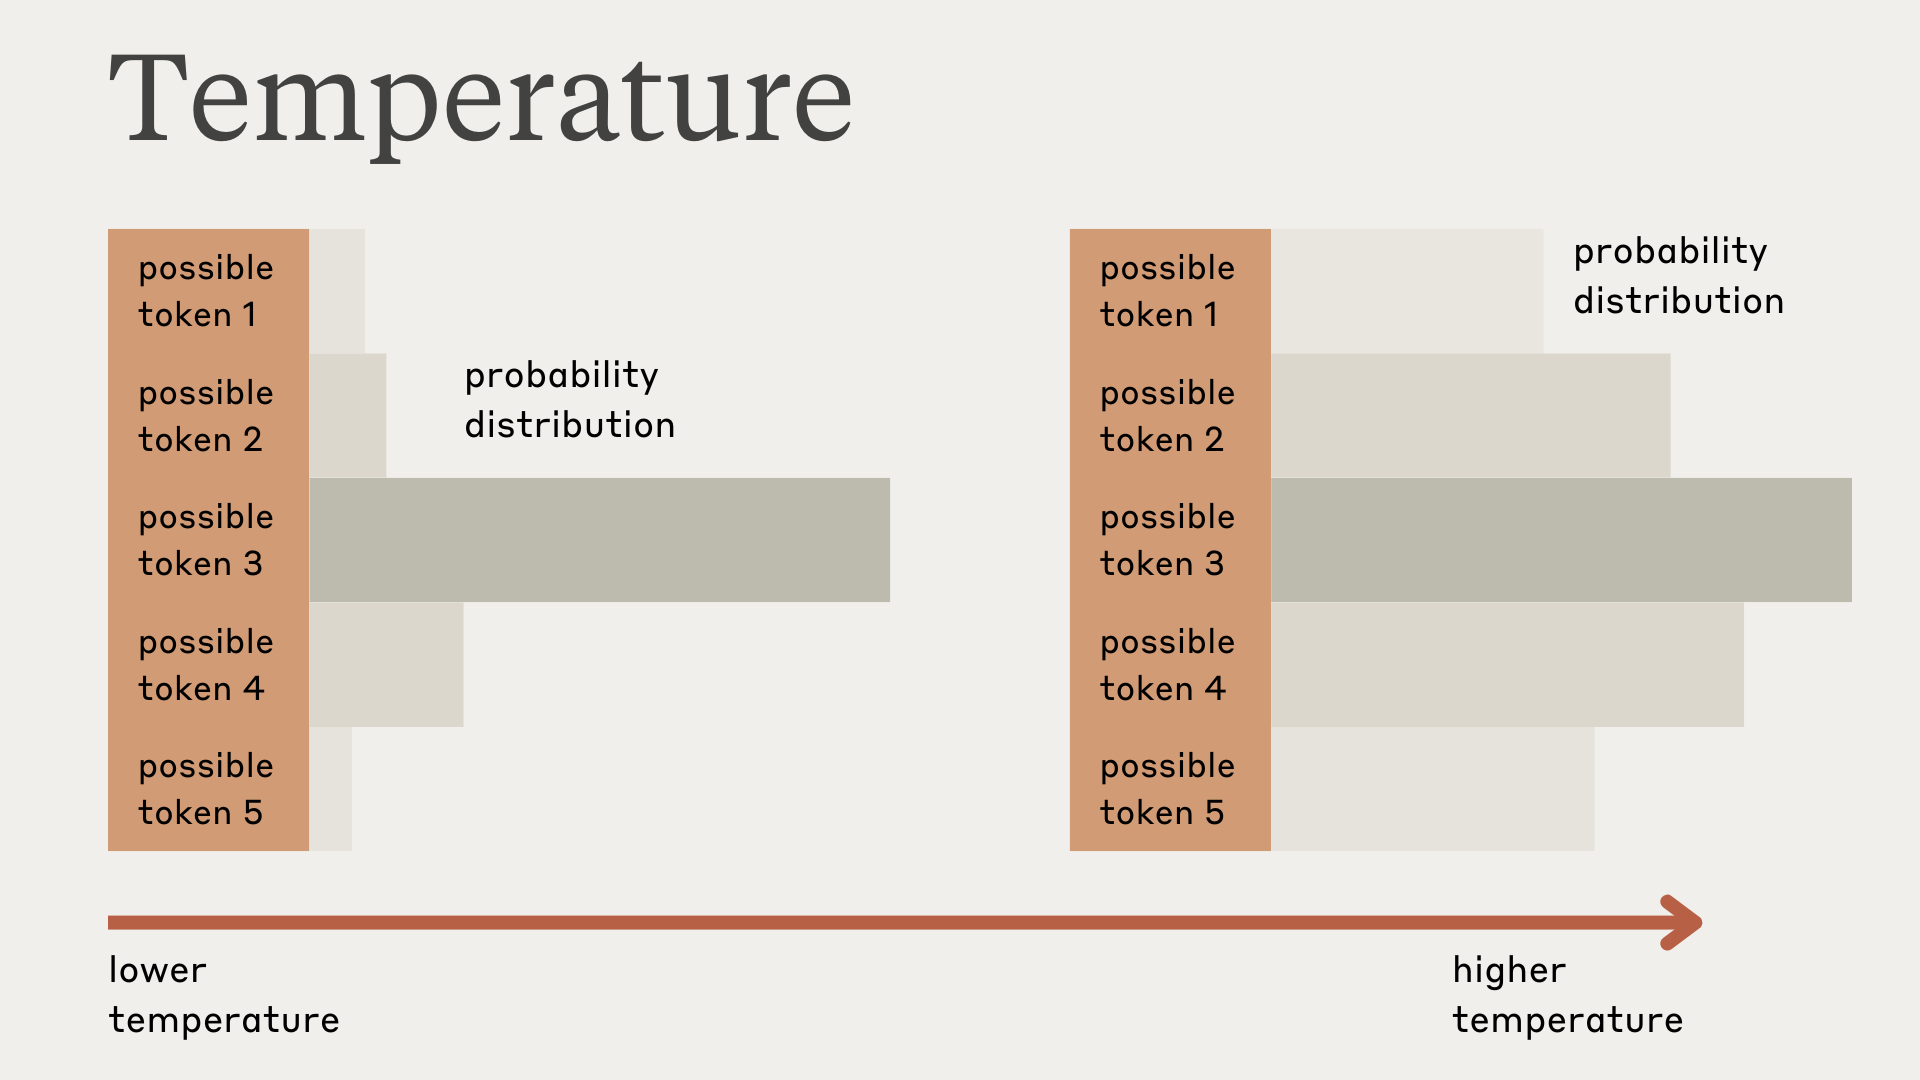


Why would you change temperature?

**Use temperature closer to 0.0 for analytical tasks, and closer to 1.0 for creative and generative tasks.**



Let's try a quick demonstration.  Take a look at the function below.  Using a temperature of 0 and then a temperature of 1, we make three requests to Claude, asking it to "Come up with a name for an alien planet. Respond with a single word." 

In [6]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "Come up with a name for an alien planet. Respond with a single word."}]
}]


def demonstrate_temperature():
    temperatures = [0, 1]
    for temperature in temperatures:
        print(f"Prompting Claude three times with temperature of {temperature}")
        print("================")
        for i in range(3):
            inference_config={"temperature":temperature}

            # Send the message.
            response = bedrock_client.converse(
                modelId=model_id,
                messages=messages,
                inferenceConfig=inference_config,
            )
            print(f"Response {i+1}: {response['output']['message']['content'][0]['text']}")
        

In [7]:
demonstrate_temperature()

Prompting Claude three times with temperature of 0
Response 1: Kestrax
Response 2: Kestrax
Response 3: Kestrax
Prompting Claude three times with temperature of 1
Response 1: Kestralia
Response 2: Keylora
Response 3: Xylora


Below is a chart that illustrates the impact temperature can have on Claude's outputs.  Using this prompt, "Pick any animal in the world. Respond with only a single word: the name of the animal," we queried Claude 100 times with a temperature of 0.  We then did it 100 more times, but with a temperature of 1.  The plot below shows the frequencies of each animal response Claude came up with.

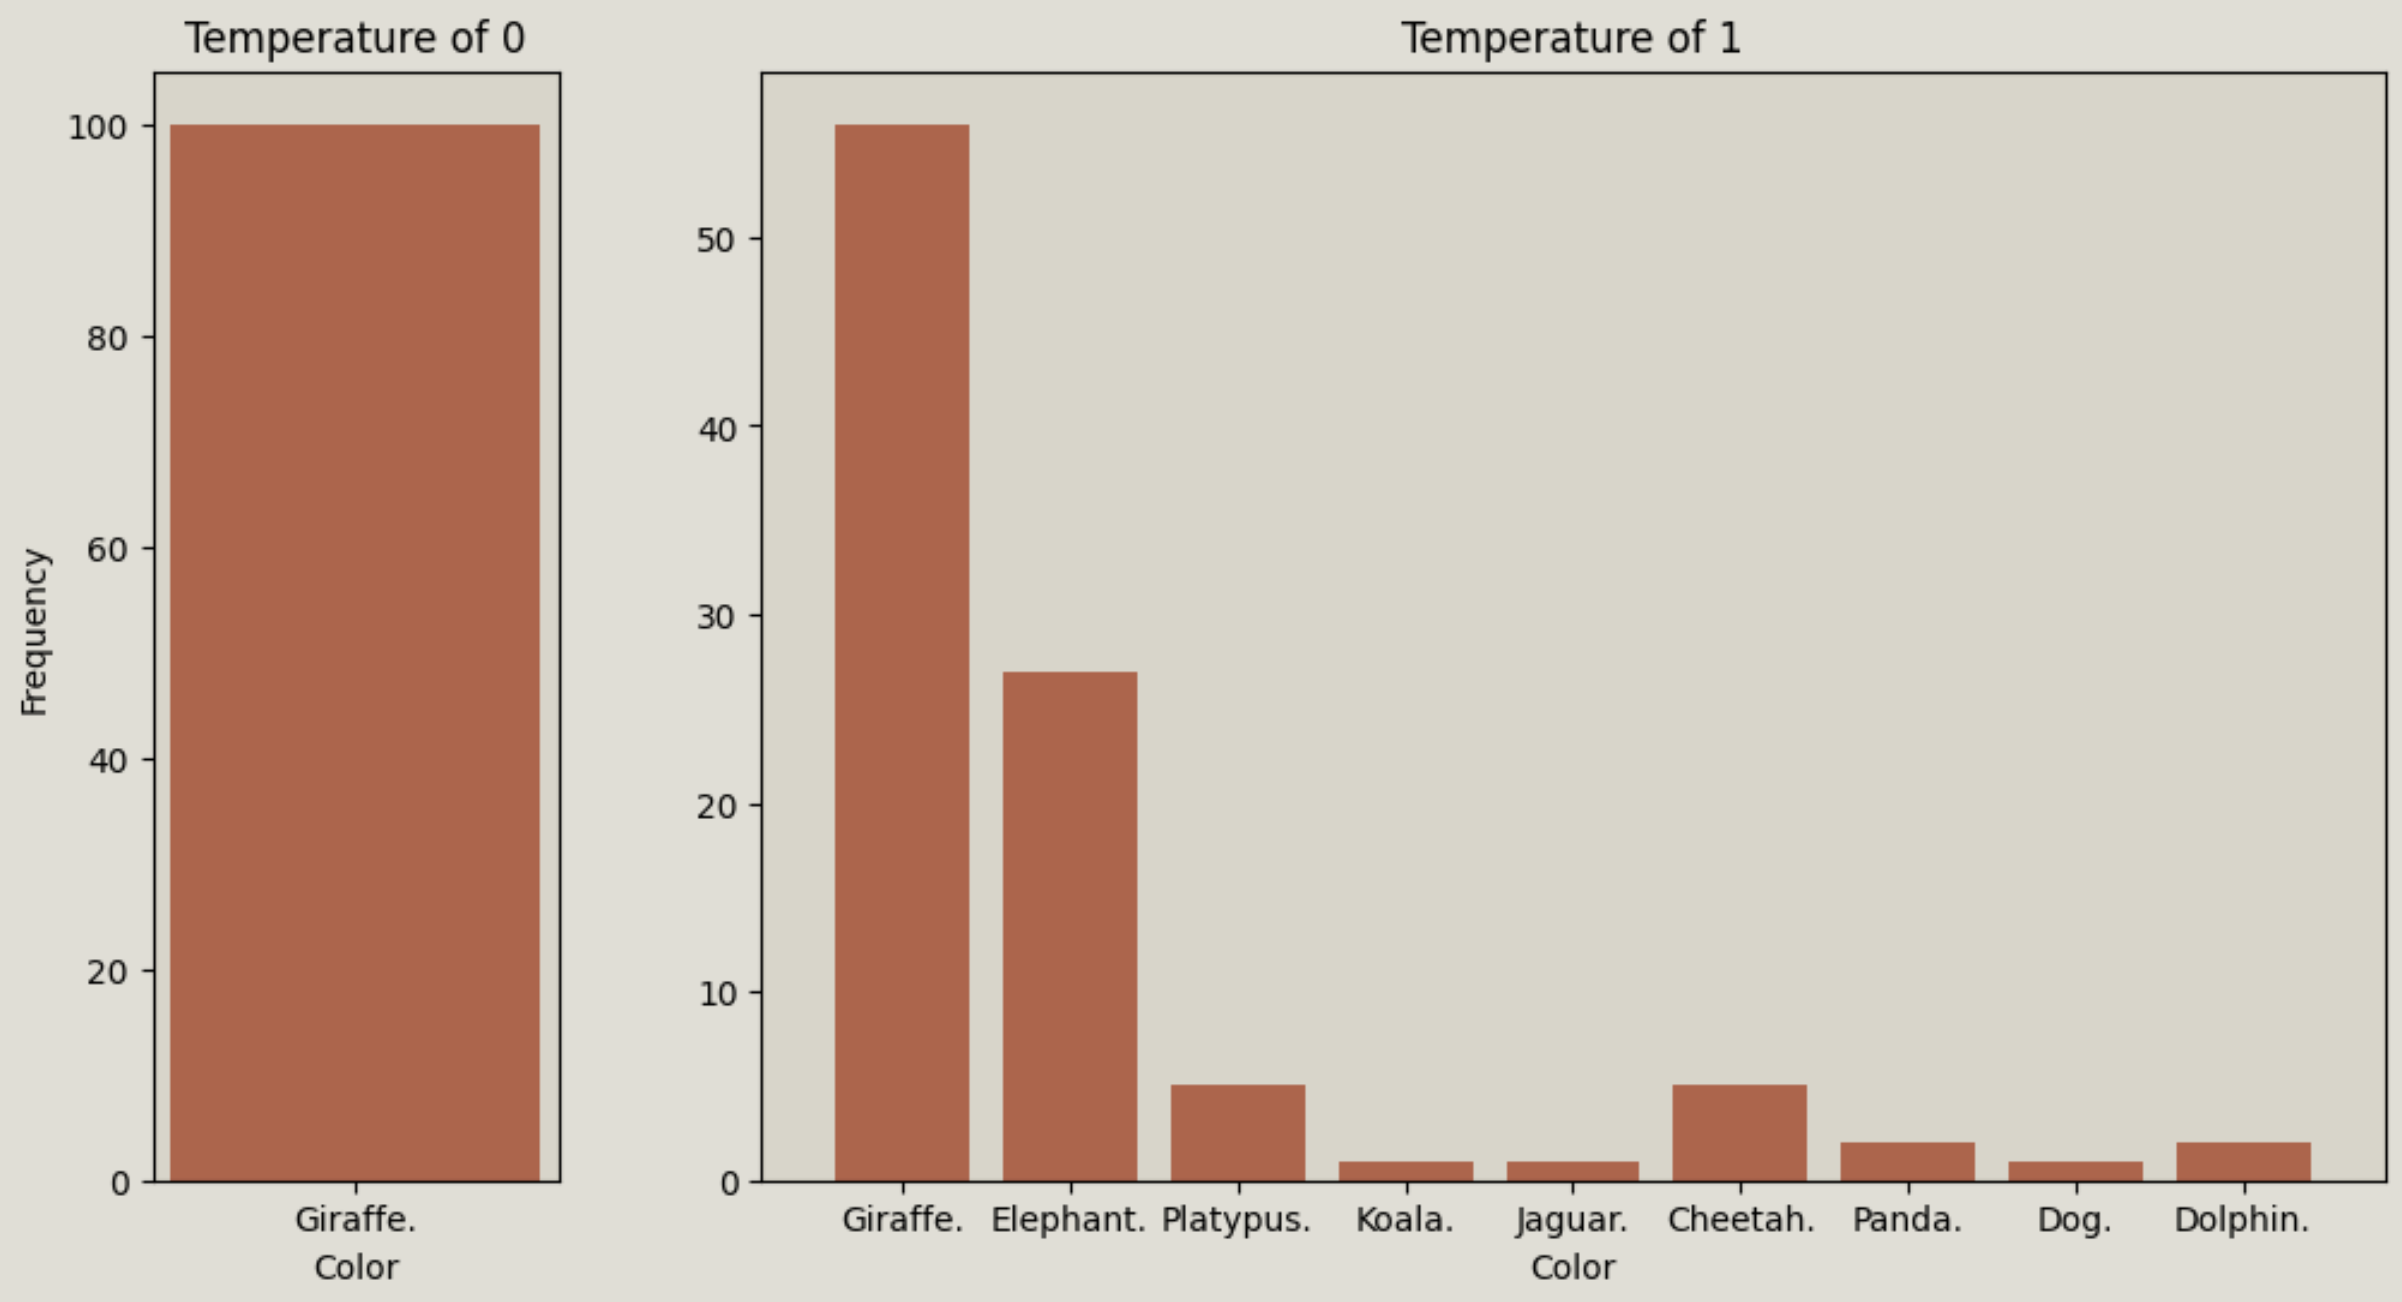

As you can see, with a temperature of 0, Claude responded with "Giraffe" every single time. Please remember that a temperature of 0 does not guarantee deterministic results, but it does make Claude much more likely to respond with similar content each time.  With a temperature of 1, Claude still chose giraffe more than half the time, but the responses also include many other types of animals!

## Stop Sequences

In [18]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "generate a poem that uses all letters of the alphabet"}]
}]



def generate_random_letters_3_times():
    for i in range(3):
        inference_config={"stopSequences":["b","c"]}
        response = bedrock_client.converse(
            modelId=model_id,
            messages=messages,
            inferenceConfig=inference_config,
        )


        if response['stopReason'] == 'stop_sequence':
            print(f"Response {i+1} of {response['output']['message']['content'][0]['text']} stopped")

In [19]:
generate_random_letters_3_times()

Response 1 of Here's an alpha stopped
Response 2 of Here's a poem that uses all letters of the alpha stopped
Response 3 of Here's an alpha stopped


## System prompt

The `system_prompt` is an optional parameter you can include when sending messages to Claude. It sets the stage for the conversation by giving Claude high-level instructions, defining its role, or providing background information that should inform its responses.

Key points about the system_prompt:

* It's optional but can be useful for setting the tone and context of the conversation.
* It's applied at the conversation level, affecting all of Claude's responses in that exchange.
* It can help steer Claude's behavior without needing to include instructions in every user message.

Note that for the most part, only tone, context, and role content should go inside the system prompt. Detailed instructions, external input content (such as documents), and examples should go inside the first `User` turn for better results. You do not need to repeat this for every subsequent `User` turn.

Let's try it out: 

In [ ]:
bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

messages = [{
    "role": "user",
    "content": [{"text": "Hey there, how are you?!"}]
}]

inference_config={"maxTokens":100}

# Send the message.
response = bedrock_client.converse(
    modelId=model_id,
    system=[{"text": "You are a helpful foreign language tutor that always responds in French."}],
    messages=messages,
    inferenceConfig=inference_config,
)

In [ ]:
response

{'ResponseMetadata': {'RequestId': '93198670-67d6-4c5b-ae20-2fc75717dd4f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 12 Nov 2024 22:43:36 GMT',
   'content-type': 'application/json',
   'content-length': '311',
   'connection': 'keep-alive',
   'x-amzn-requestid': '93198670-67d6-4c5b-ae20-2fc75717dd4f'},
  'RetryAttempts': 0},
 'output': {'message': {'role': 'assistant',
   'content': [{'text': "Bonjour ! Je vais très bien, merci ! Et vous, comment allez-vous ? \n\n(Hello! I'm doing very well, thank you! And how are you?)"}]}},
 'stopReason': 'end_turn',
 'usage': {'inputTokens': 29, 'outputTokens': 45, 'totalTokens': 74},
 'metrics': {'latencyMs': 1208}}

***

## Exercise

Write a function called `generate_questions` that does the following:
* Takes two parameters: `topic` and `num_questions`
* Generates `num_questions` thought-provoking questions about the provided `topic` as a numbered list
* Prints the generated questions

For example, calling `generate_questions(topic="free will", num_questions=3)` could result in the following output:


> 1. To what extent do our decisions and actions truly originate from our own free will, rather than being shaped by factors beyond our control, such as our genes, upbringing, and societal influences?
> 2. If our decisions are ultimately the result of a complex interplay of biological, psychological, and environmental factors, does that mean we lack the ability to make authentic, autonomous choices, or is free will compatible with determinism?
> 3. What are the ethical and philosophical implications of embracing or rejecting the concept of free will? How might our views on free will impact our notions of moral responsibility, punishment, and the nature of the human condition?


In your implementation, please make use of the following parameters:
* `max_tokens` to limit the response to under 1000 tokens
* `system` to provide a system prompt telling the model it is an expert on the particular `topic` and should generate a numbered list.
* `stop_sequences` to ensure the model stops after generating the correct number of questions. (If we ask for 3 questions, we want to make sure the model stops as soon as it generates "4." If we ask for 5 questions, we want to make sure the model stops as soon as it generates "6.")


#### Potential solution

In [20]:
def generate_questions(topic, num_questions=3):

    bedrock_client = boto3.client(service_name='bedrock-runtime', region_name="us-west-2")
    model_id = "anthropic.claude-3-5-sonnet-20241022-v2:0"

    messages = [{
        "role": "user",
        "content": [{"text": f"Generate {num_questions} questions about {topic} as a numbered list."}]
    }]

    inference_config={"maxTokens":100, "stopSequences": [f"{num_questions+1}."]}

    # Send the message.
    response = bedrock_client.converse(
        modelId=model_id,
        system=[{"text": f"You are an expert on {topic}. Generate thought-provoking questions about this topic."}],
        messages=messages,
        inferenceConfig=inference_config,
    )

    return response

In [21]:
generate_questions(topic="free will", num_questions=3)

{'ResponseMetadata': {'RequestId': '53bf9fbb-e07c-4de2-a079-db9bfb145760',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 14 Nov 2024 19:23:30 GMT',
   'content-type': 'application/json',
   'content-length': '694',
   'connection': 'keep-alive',
   'x-amzn-requestid': '53bf9fbb-e07c-4de2-a079-db9bfb145760'},
  'RetryAttempts': 0},
 'output': {'message': {'role': 'assistant',
   'content': [{'text': '1. If our decisions are influenced by our past experiences, genetics, and environmental factors that we didn\'t choose, to what extent can we claim that our choices are truly "free"?\n\n2. In a world where we can increasingly predict human behavior through data and neuroscience, does this scientific determinism eliminate the possibility of free will, or does it simply describe the mechanisms through which we exercise it?\n\n3. How does the concept of free will align with various religious beliefs about'}]}},
 'stopReason': 'max_tokens',
 'usage': {'inputTokens': 39, 'outputTokens

***